# Regressão Linear com PyTorch

Aluna: Karina Meireles Varela
kmv@cesar.school
2025.1

Professor: Vitor Casadei

## Objetivos

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se:
- a função de perda MSE do PyTorch,
- treinamento dos parâmetros via gradiente descendente usando o otimizador.
- A rede é criada com uma camada nn.Linear()

## Importação dos pacotes

In [2]:
# http://pytorch.org/
!pip install torch torchvision torchaudio
import torch

In [3]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

torch.manual_seed(1234)

## Leitura dos dados

In [4]:
iris = load_iris()
data = iris.data[iris.target==1,::2]

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [5]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [6]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [7]:
x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)

## Criação do modelo da rede

In [8]:
model = torch.nn.Linear(2, 1, bias=False)

### Verificando a inicialização dos parâmetros

In [9]:
model.weight.data = torch.zeros(1,2)
torch.nn.init.uniform(model.weight.data, -0.1, 0.1)
model.weight.data

/tmp/ipython-input-1486225639.py:2: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  torch.nn.init.uniform(model.weight.data, -0.1, 0.1)


tensor([[-0.0480, -0.0267]])

### Testando o predict da rede

In [10]:
model(Variable(torch.ones((5,2))))

tensor([[-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747]], grad_fn=<MmBackward0>)

## Treinamento

### Definindo função de perda e otimizador

In [11]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)

### Laço de treinamento

In [12]:
num_epochs = 120
w0_list = []
w1_list = []
for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)

    # forward - predict
    out = model(inputs)

    w0_list.append(model.weight.data[0][0].item())
    w1_list.append(model.weight.data[0][1].item())

    #loss cálculo da função de perda
    loss = criterion(out, target)

    # backward e otimizador
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))

Epoch[20/120], loss: 0.024990
Epoch[40/120], loss: 0.022381
Epoch[60/120], loss: 0.021554
Epoch[80/120], loss: 0.021291
Epoch[100/120], loss: 0.021208
Epoch[120/120], loss: 0.021182


## Avaliação

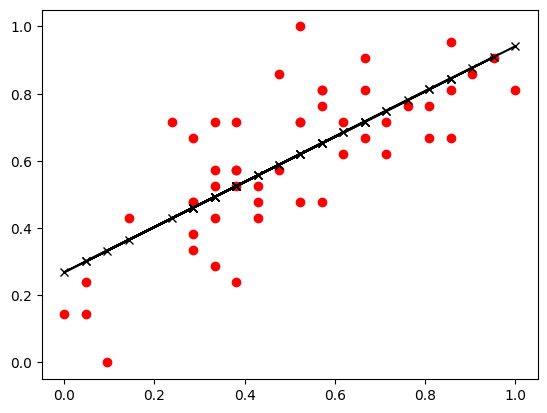

In [13]:
y_pred = model(Variable(x_train_bias))
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

In [14]:
y_pred = model(Variable(x_train_bias))
loss = criterion(y_pred, Variable(y_train))
print(loss)

tensor(0.0212, grad_fn=<MseLossBackward0>)


# Exercícios

- 1) Calcule o valor da função de custo (MSE) depois da rede treinada, utilizando a
   função `criterion` utilizada no laço de treinamento.

In [15]:
# função de custo da perda
with torch.no_grad():
  predictions = model(Variable(x_train_bias))
  final_mse = criterion(predictions, Variable(y_train))
  print("Função MSE depois do treinamento: ",final_mse.item())

Função MSE depois do treinamento:  0.021181009709835052


- 2) Faça igual o exercício do notebook anterior, de plotar um gráfico scatterplot para
   mostrar a evolução dos parâmetros durante o treinamento pelo gradiente descendente.

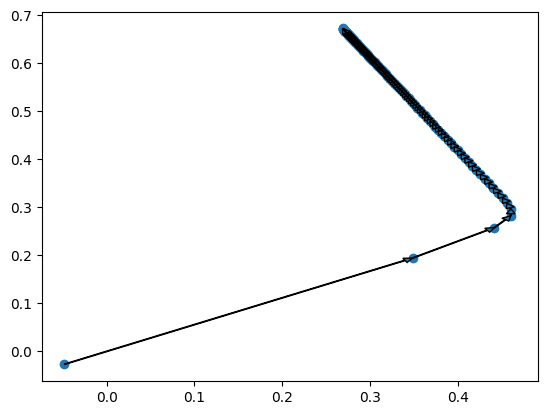

In [16]:
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1

- 3) Procure sobrepor a função de perda neste gráfico. (exercício mais difícil).

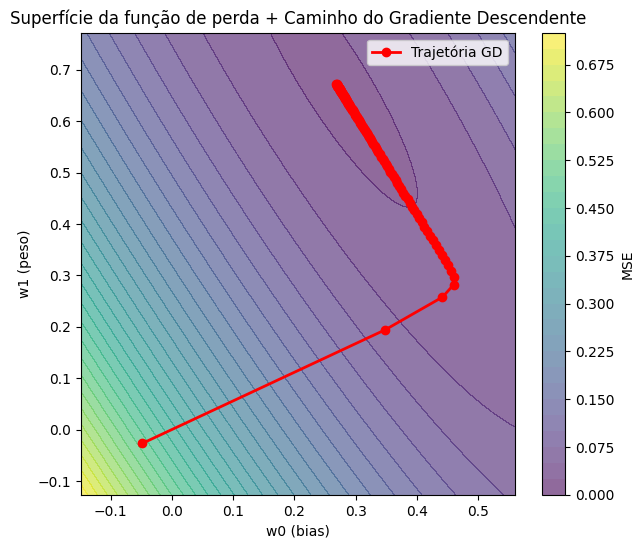

In [17]:
# Grade de valores para w0 e w1
w0_range = torch.linspace(min(w0_list)-0.1, max(w0_list)+0.1, 80)
w1_range = torch.linspace(min(w1_list)-0.1, max(w1_list)+0.1, 80)

W0, W1 = torch.meshgrid(w0_range, w1_range, indexing='ij')

Z = torch.zeros_like(W0)

for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        w = torch.tensor([[W0[i,j], W1[i,j]]], dtype=torch.float32)
        y_pred_grid = x_train_bias.mm(w.T)
        Z[i,j] = ((y_train - y_pred_grid)**2).mean()

# Mapa de calor da função de perda
plt.figure(figsize=(7,6))
cs = plt.contourf(W0, W1, Z, levels=30, alpha=0.6)
plt.colorbar(cs, label="MSE")

# Pesos treinando
plt.plot(w0_list, w1_list, color='red', marker='o', linewidth=2, label='Trajetória GD')

plt.xlabel("w0 (bias)")
plt.ylabel("w1 (peso)")
plt.title("Superfície da função de perda + Caminho do Gradiente Descendente")
plt.legend()
plt.show()



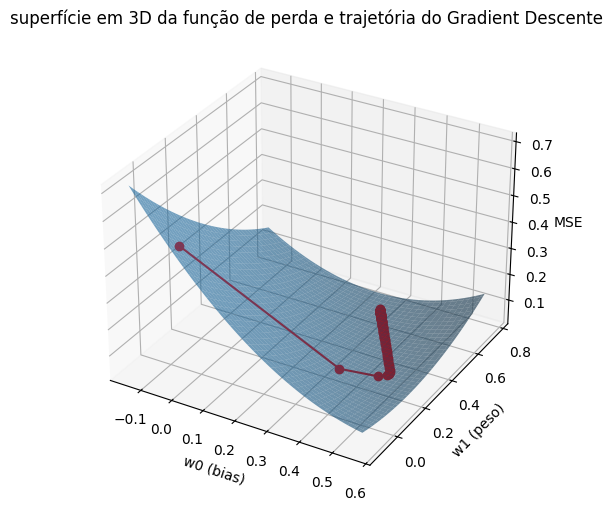

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(W0.numpy(), W1.numpy(), Z.numpy(), alpha=0.6)

ax.plot(w0_list, w1_list,
        [((y_train - x_train_bias @ torch.tensor([[w0, w1]]).T)**2).mean().item() for w0,w1 in zip(w0_list,w1_list)],
        color='red', marker='o')

ax.set_xlabel('w0 (bias)')
ax.set_ylabel('w1 (peso)')
ax.set_zlabel('MSE')
ax.set_title('superfície em 3D da função de perda e trajetória do Gradient Descente')
plt.show()


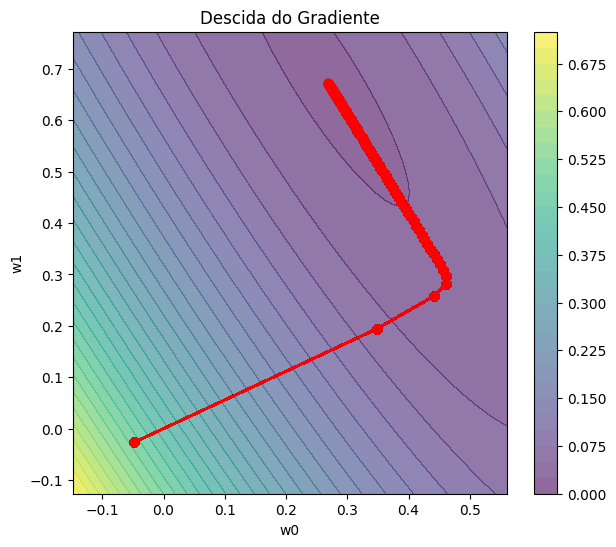

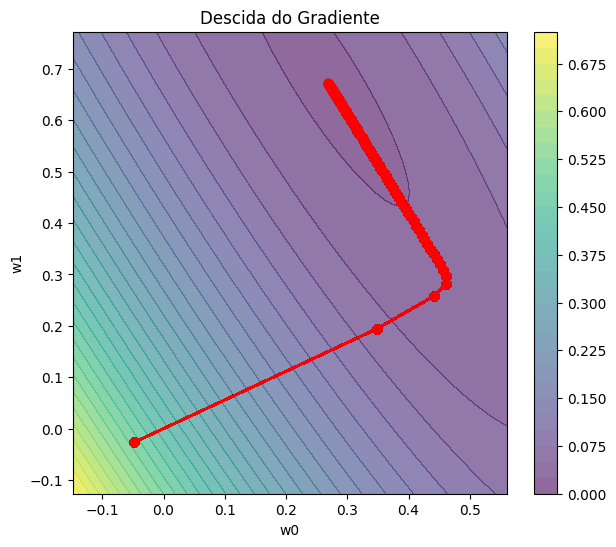

In [20]:
import time
from IPython import display

plt.figure(figsize=(7,6))
cs = plt.contourf(W0, W1, Z, levels=30, alpha=0.6)
plt.colorbar(cs)
plt.xlabel("w0")
plt.ylabel("w1")
plt.title("Descida do Gradiente")

for i in range(len(w0_list)):
    plt.plot(w0_list[:i+1], w1_list[:i+1], color='red', marker='o')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.1)

# Aprendizados

Durante o treinamento do modelo de regressão linear, os pesos w0 (bias) e w1 (peso) foram ajustados para reduzir o erro entre as previsões e os valores reais.

Ao acompanhar os valores de w0 e w1 a cada época, foi possível ver como eles se movem em direção ao ponto onde o erro é mínimo. Isso ficou claro no gráfico, onde a função de perda (MSE) mostra a trajetória do gradiente descendente, como uma "descida em direção ao fundo de uma tigela".

O gráfico 3D reforçou a ideia de como o modelo ajusta os pesos passo a passo, sempre tentando diminuir o erro.